In [150]:
#data
import pandas as pd
import os
import json
import numpy as np

In [151]:
#plotting
import matplotlib
import seaborn as sns
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

In [152]:
def Merge(dict1, dict2):
    '''
    Function to merge python dictionaries
    '''
    res = {**dict1, **dict2}
    return res

In [153]:
def format4vep(snps,col):
    '''
    Function to format for VEP
    '''
    vep=pd.DataFrame({"snps":snps[col]})
    vep=vep["snps"].str.split(":",expand=True)
    vep[3]=vep[3].astype(str)+"/"+vep[2].astype(str)
    vep[2]=vep[1]
    vep[4]="+"
    vep[5]=snps[col]
    vep[0]=vep[0].str.replace("X","23")
    vep[0]=pd.to_numeric(vep[0])
    vep[1]=pd.to_numeric(vep[1])
    vep[2]=pd.to_numeric(vep[2])
    
    vep=vep.sort_values(by=[0, 2])
    vep[0]=vep[0].astype(str)
    return(vep)

In [154]:
with open('/cellar/users/mpagadal/resources/tcga/ensembl_map.json', 'r') as f:
    ensembl = json.load(f)
ensembl={k.split(".")[0]:v for k,v in ensembl.items()}

## Get summary statistics

In [7]:
#get corresponding summary stats
direct="../data/summarystats/extract_/"
compiled_stats=pd.DataFrame()
for x in [x for x in os.listdir(direct)]:
    df=pd.read_csv(direct+x,delimiter="\t")
    df["file"]=x
    df["pheno"]=x.split(".")[2]
    df["group"]=x.split(".")[1]
    if x.split(".")[2]=="hypogonad":
        df["BETA"]=np.log(df["OR"])
        df["SE"]=df["LOG(OR)_SE"]
    compiled_stats=compiled_stats.append(df)
compiled_stats["SNP"]=compiled_stats["ID"]

## Ancestry associations

In [8]:
# get significant associations
direct="../data/clumps/"
files=[x for x in os.listdir(direct) if "sig" in x]
files=[x for x in files if "all" not in x]

compiled_ancestry=pd.DataFrame()
for x in files:
    try:
        df=pd.read_csv(direct+x)
        df["pheno"]=x.split(".")[0]
        compiled_ancestry=compiled_ancestry.append(df)
    except:
        pass
    
compiled_ancestry["group"]=compiled_ancestry["file"].str.split(".").str[0]
compiled_ancestry=compiled_ancestry[["CHR","F","SNP","BP","P","pheno","group"]]
compiled_ancestry=pd.merge(compiled_ancestry,compiled_stats[["SNP","pheno","A1","BETA","SE","group"]], on=["SNP","pheno","group"],how="left")

In [9]:
compiled_ancestry.to_csv("../data/supplemental/tables3.csv",index=None)

### METAL

In [10]:
direct="../data/metal/"
files=[x for x in os.listdir(direct) if "csv" in x]

compiled_metal=pd.DataFrame()
for x in files:
    df=pd.read_csv(direct+x)
    df["file"]=x
    df["pheno"]=x.split(".")[2]
    compiled_metal=compiled_metal.append(df)
del compiled_metal["Unnamed: 0"]

In [11]:
compiled_metal_stats=pd.DataFrame()

for x in ["total","free","shbg"]:
    print(x)
    metal=pd.read_csv("/cellar/users/mpagadal/Programs/metal/testosterone/"+x+"/METAANALYSIS1.TBL",delim_whitespace=True)
    metal_sig=metal[metal["MarkerName"].isin(compiled_metal[compiled_metal["pheno"]==x]["SNP"].tolist())]
    metal_sig["pheno"]=x
    compiled_metal_stats=compiled_metal_stats.append(metal_sig)

total


/tmp/ipykernel_3158443/4097617899.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metal_sig["pheno"]=x


free
shbg


In [12]:
metal=pd.read_csv("/cellar/users/mpagadal/Programs/metal/testosterone/hypogonad_filt/METAANALYSIS1.TBL",delim_whitespace=True)
metal["pheno"]="hypogonad"
compiled_metal_stats=compiled_metal_stats.append(metal)

In [13]:
compiled_metal_stats=compiled_metal_stats.rename(columns={"MarkerName":"SNP"})
compiled_metal=pd.merge(compiled_metal,compiled_metal_stats,on=["SNP","pheno"],how="left")

#### convert to hg19

In [14]:
all_snps=compiled_ancestry["SNP"].unique().tolist()+compiled_metal["SNP"].unique().tolist()
liftover=pd.DataFrame({"snps":all_snps})
liftover["snps"]=liftover["snps"].str.replace("chr","")
liftover["chr"]=liftover["snps"].str.split(":").str[0]
liftover["bp"]=liftover["snps"].str.split(":").str[1]
liftover["bp"]=liftover["bp"].astype(int)
liftover["bp2"]=liftover["bp"]+1
liftover["chr"]="chr"+liftover["chr"]
liftover[["chr","bp","bp2","snps"]].to_csv("../data/testosterone.hg38.bed",index=None,header=None,sep="\t")

#run liftover
#~/Programs/liftOver testosterone.hg38.bed ~/Programs/liftover-files/hg38ToHg19.over.chain.gz testosterone.hg19.bed unlifted.bed

lifted=pd.read_csv("../data/testosterone.hg19.bed",header=None,delimiter="\t")
lifted["hg19"]=lifted[3].str.split(":").str[0]+":"+lifted[1].astype(str)+":"+lifted[3].str.split(":").str[2]+":"+lifted[3].str.split(":").str[3]
snps=lifted["hg19"].tolist()+[x.rsplit(":",2)[0]+":"+x.split(":")[3]+":"+x.split(":")[2] for x in lifted["hg19"]]
pd.DataFrame({"snps":snps})["snps"].to_csv("../data/extract.testosterone.snps.hg19.txt",header=None,index=None)

## VEP

In [15]:
compiled_snps=compiled_ancestry[["SNP","pheno","group"]].append(compiled_metal[["SNP","pheno"]])
compiled_snps["SNP"]=compiled_snps["SNP"].str.replace("chr","")
vep_input=format4vep(compiled_snps,"SNP")
vep_input.to_csv("../data/vep/vep_input.txt",header=None,index=None,sep="\t")

In [17]:
len(compiled_snps["SNP"].unique())

269

In [16]:
vep_output=pd.read_csv("../data/vep/VaAdklYUMBFtegMP.txt",delimiter="\t")
vep_output["#Uploaded_variation"]="chr"+vep_output["#Uploaded_variation"]
df_consequence=vep_output[["#Uploaded_variation","Consequence"]].drop_duplicates().groupby('#Uploaded_variation')['Consequence'].apply(lambda x: ','.join(x)).reset_index()
df_gene=vep_output[["#Uploaded_variation","SYMBOL"]].drop_duplicates().groupby('#Uploaded_variation')['SYMBOL'].apply(lambda x: ','.join(x)).reset_index()

In [18]:
annotated=vep_output[vep_output["SYMBOL"]!="-"]["#Uploaded_variation"].unique()

In [19]:
missense_variants=vep_output[vep_output["Consequence"].str.contains("missense")]["#Uploaded_variation"].unique().tolist()

In [20]:
df_consequence=vep_output[["#Uploaded_variation","Consequence"]].drop_duplicates().groupby('#Uploaded_variation')['Consequence'].apply(lambda x: ','.join(x)).reset_index()
df_gene=vep_output[["#Uploaded_variation","SYMBOL"]].drop_duplicates().groupby('#Uploaded_variation')['SYMBOL'].apply(lambda x: ','.join(x)).reset_index()

mp_consequence=dict(zip(df_consequence["#Uploaded_variation"],df_consequence["Consequence"]))
mp_gene=dict(zip(df_gene["#Uploaded_variation"],df_gene["SYMBOL"]))

compiled_ancestry["consequence"]=compiled_ancestry["SNP"].map(mp_consequence)
compiled_ancestry["gene"]=compiled_ancestry["SNP"].map(mp_gene)
compiled_ancestry["missense"]=np.where(compiled_ancestry["SNP"].isin(missense_variants),"missense","")

compiled_metal["consequence"]=compiled_metal["SNP"].map(mp_consequence)
compiled_metal["gene"]=compiled_metal["SNP"].map(mp_gene)
compiled_metal["missense"]=np.where(compiled_metal["SNP"].isin(missense_variants),"missense","")

In [21]:
compiled_metal.to_csv("../data/supplemental/tables4.csv",index=None)

### METAL

### Export associations to networkx for visualization (replace with metal variants)

In [22]:
node1=[]
node2=[]

for i,row in compiled_metal.iterrows():
    try:
        for gene in row["gene"].split(","):
            node1.append(row["SNP"])
            node2.append(gene)
        node1.append(row["SNP"])
        node2.append(row["pheno"])
    
    except:
        
        node1.append(row["SNP"])
        node2.append(row["pheno"])

df=pd.DataFrame({"node1":node1,"node2":node2})
df=df[df["node2"]!="-"]
df=df.drop_duplicates()
df.to_csv("../data/networkx/networkx.csv",index=None)

nodes=[x for x in set(node1)]+[x for x in set(node2)]
df_node=pd.DataFrame({"nodes":nodes})
df_node["type"]=np.where(df_node['nodes'].str.contains(":"),"snp","gene")
df_node["type"]=np.where(df_node["nodes"].isin(["shbg","hypogonad","free","total"]),"pheno",df_node["type"])
df_node["display_name"]=np.where(df_node["nodes"].str.contains(":"),"",df_node["nodes"])

df_pheno_counts=compiled_metal["pheno"].value_counts().reset_index()
mp_pheno_size=dict(zip(df_pheno_counts["index"],df_pheno_counts["pheno"]))

node1=[]
node2=[]

for i,row in compiled_metal.iterrows():
    try:
        for gene in row["gene"].split(","):
            node1.append(row["pheno"])
            node2.append(gene)
    except:
        pass    

df_gene_counts=pd.DataFrame({"node1":node1,"node2":node2})
df_gene_counts=df_gene_counts[df_gene_counts["node2"]!="-"]
df_gene_counts=df_gene_counts.drop_duplicates()
df_gene_counts=df_gene_counts["node2"].value_counts().reset_index()
mp_gene_size=dict(zip(df_gene_counts["index"],df_gene_counts["node2"]))
mp_size=Merge(mp_pheno_size,mp_gene_size)
df_node["size"]=df_node["nodes"].map(mp_size).fillna(0)
df_node["size"]=np.where(df_node["type"]!="pheno",df_node["size"]*10,df_node["size"])
df_node.to_csv("../data/networkx/networkx.node.csv",index=None)

### look at effect sizes across ancestry groups

In [23]:
len(compiled_metal["SNP"].unique())

171

In [24]:
def format_clustermap(stats_df, trans_df, pheno):
    # get trans-ancestry SNPs
    compiled_stats_group=stats_df[stats_df["SNP"].isin(trans_df[trans_df["pheno"]==pheno]["SNP"].tolist())]
    compiled_stats_group=compiled_stats_group[compiled_stats_group["pheno"]==pheno]
    
    compiled_stats_group_oriented=pd.DataFrame()
    #orient SNPs correctly
    for x in compiled_stats_group["ID"].unique():
        a1=compiled_stats_group[compiled_stats_group["ID"]==x]["A1"].value_counts().reset_index()["index"].tolist()[0]
        compiled_stats_snp=compiled_stats_group[compiled_stats_group["ID"]==x]
        compiled_stats_snp["BETA"]=np.where(compiled_stats_snp["A1"]!=a1,compiled_stats_snp["BETA"]*-1,compiled_stats_snp["BETA"])
        compiled_stats_snp["A1"]=a1
        compiled_stats_group_oriented=compiled_stats_group_oriented.append(compiled_stats_snp)
    compiled_stats_group_oriented["group_index"]=compiled_stats_group_oriented["group"].map({"EUR":0,"AFR":1,"AMR":2,"EAS":3})
    compiled_stats_group_oriented["#CHROM"]=compiled_stats_group_oriented["#CHROM"].replace("X","23")
    compiled_stats_group_oriented["#CHROM"]=compiled_stats_group_oriented["#CHROM"].astype(int)
    compiled_stats_group_oriented["POS"]=compiled_stats_group_oriented["POS"].astype(int)
    return(compiled_stats_group_oriented.sort_values(by=["group_index","#CHROM","POS"],ascending=[False,True,True]))
#     return(compiled_stats_group_oriented.pivot(index="group",columns="ID",values="BETA"))  

In [25]:
def heatmap(x, y, size,color):
    fig, ax = plt.subplots(figsize=(25, 5))
    
    # Mapping from column names to integer coordinates
    x_labels = [v for v in x.unique()]
    y_labels = [v for v in y.unique()]
    x_to_num = {p[1]:p[0] for p in enumerate(x_labels)} 
    y_to_num = {p[1]:p[0] for p in enumerate(y_labels)} 
    
    size_scale = 5
    plt.scatter(
        x=x.map(x_to_num), # Use mapping for x
        y=y.map(y_to_num), # Use mapping for y
        s=size * size_scale, 
        c=color,
        cmap="RdBu_r", vmin=-.5, vmax=.5# Vector of square sizes, proportional to size parameter
    )
    
    # Show column labels on the axes
    ax.set_xticks([x_to_num[v] for v in x_labels])
    ax.set_xticklabels(x_labels, rotation=45, horizontalalignment='right')
    ax.set_yticks([y_to_num[v] for v in y_labels])
    ax.set_yticklabels(y_labels)
    plt.colorbar()
    
    plt.xticks(rotation=90)

In [26]:
compiled_stats_noall=compiled_stats[compiled_stats["group"]!="all"]

In [27]:
compiled_stats_noall.to_csv("../data/supplemental/tables4.group.stats.csv")

/tmp/ipykernel_3158443/3440527470.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compiled_stats_snp["BETA"]=np.where(compiled_stats_snp["A1"]!=a1,compiled_stats_snp["BETA"]*-1,compiled_stats_snp["BETA"])
/tmp/ipykernel_3158443/3440527470.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compiled_stats_snp["A1"]=a1


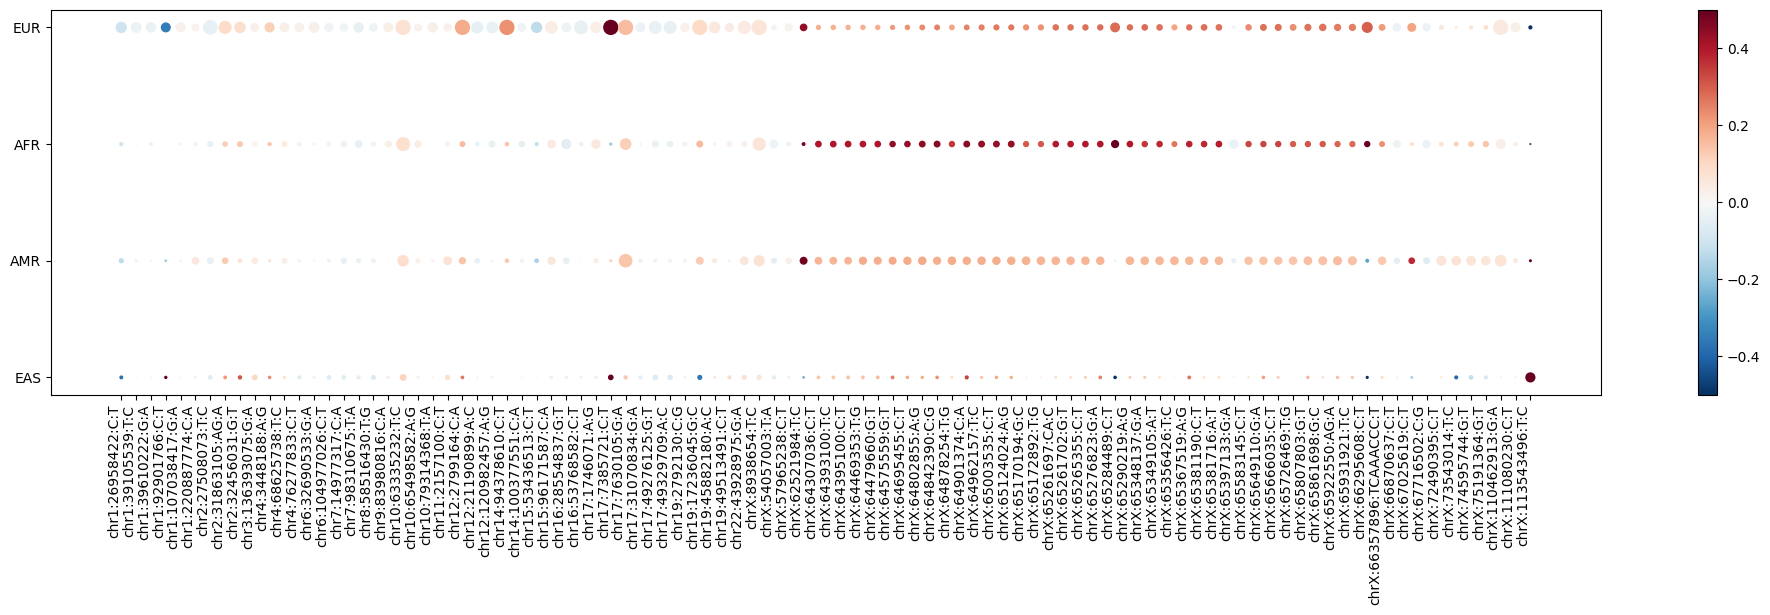

In [28]:
df_plot=format_clustermap(compiled_stats_noall, compiled_metal, "total")
df_plot["-log10p"]=-np.log10(df_plot["P"])
df_plot["-log10p"]=np.where(df_plot["-log10p"]>20,20,df_plot["-log10p"])    

heatmap(
    x=df_plot['ID'],
    y=df_plot['group'],
    size=df_plot['-log10p'],
    color=df_plot['BETA'],
)
plt.savefig("../plots/metal/total.clustermap.pdf")

/tmp/ipykernel_3158443/3440527470.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compiled_stats_snp["BETA"]=np.where(compiled_stats_snp["A1"]!=a1,compiled_stats_snp["BETA"]*-1,compiled_stats_snp["BETA"])
/tmp/ipykernel_3158443/3440527470.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compiled_stats_snp["A1"]=a1


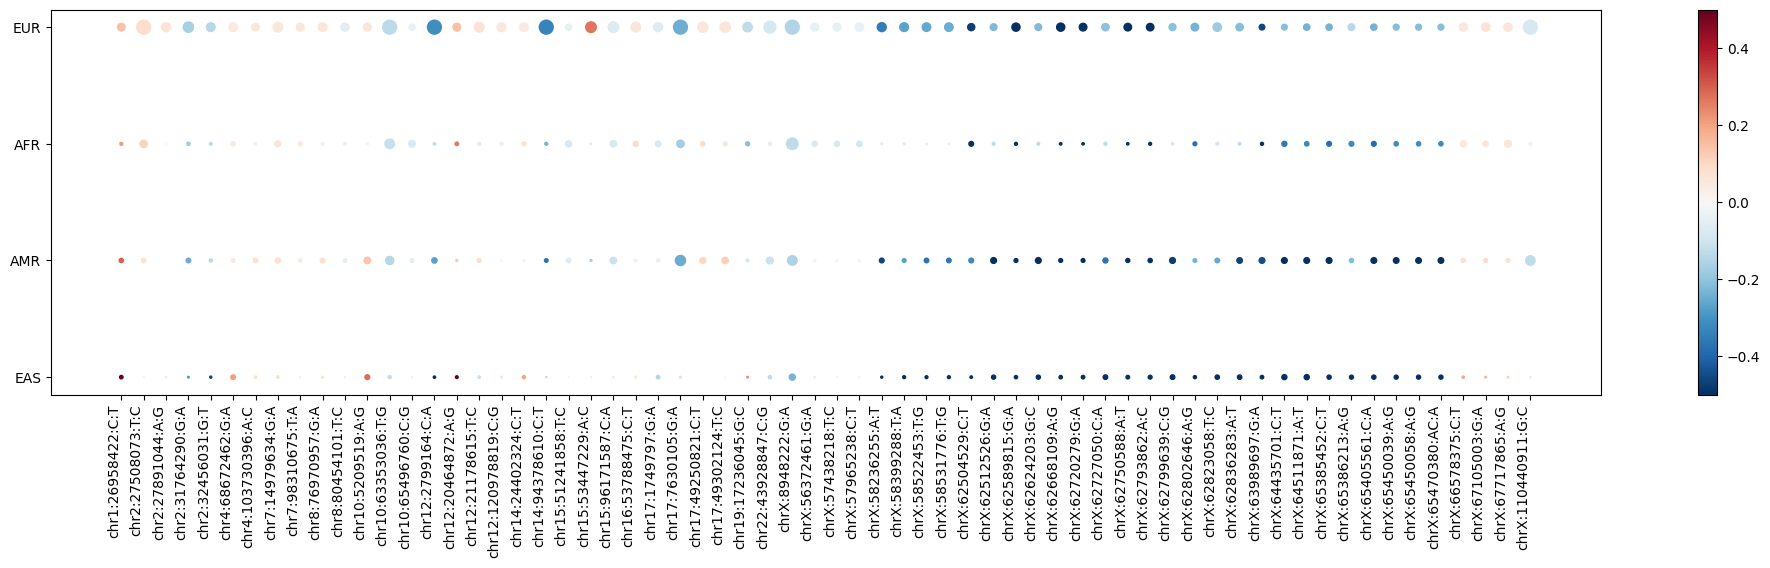

In [29]:
df_plot=format_clustermap(compiled_stats_noall, compiled_metal, "hypogonad")
df_plot["-log10p"]=-np.log10(df_plot["P"])
df_plot["-log10p"]=np.where(df_plot["-log10p"]>20,20,df_plot["-log10p"])

heatmap(
    x=df_plot['ID'],
    y=df_plot['group'],
    size=df_plot['-log10p'],
    color=df_plot['BETA'],
)
plt.savefig("../plots/metal/hypogonad.clustermap.pdf")

/tmp/ipykernel_3158443/3440527470.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compiled_stats_snp["BETA"]=np.where(compiled_stats_snp["A1"]!=a1,compiled_stats_snp["BETA"]*-1,compiled_stats_snp["BETA"])
/tmp/ipykernel_3158443/3440527470.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compiled_stats_snp["A1"]=a1


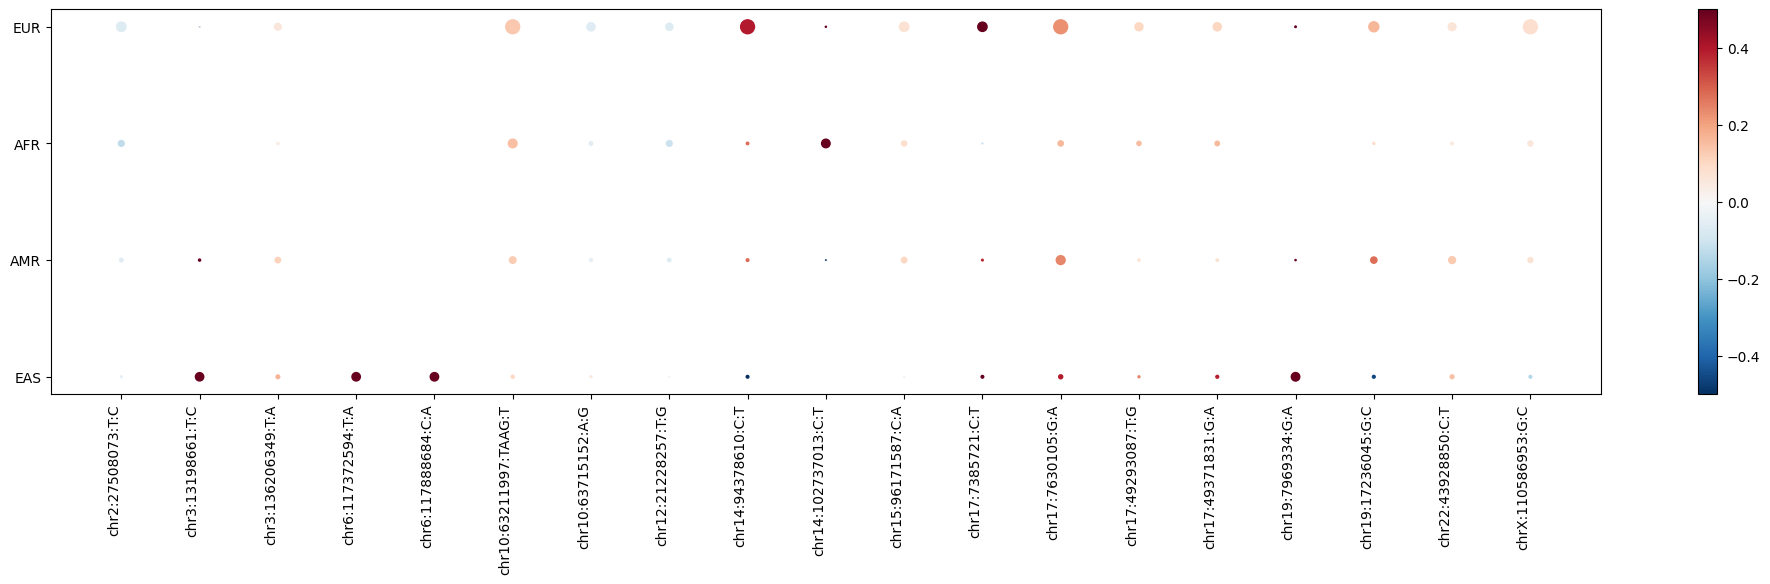

In [30]:
df_plot=format_clustermap(compiled_stats_noall, compiled_metal, "shbg")
df_plot["-log10p"]=-np.log10(df_plot["P"])
df_plot["-log10p"]=np.where(df_plot["-log10p"]>20,20,df_plot["-log10p"])

heatmap(
    x=df_plot['ID'],
    y=df_plot['group'],
    size=df_plot['-log10p'],
    color=df_plot['BETA'],
)
plt.savefig("../plots/metal/shbg.clustermap.pdf")

/tmp/ipykernel_3158443/3440527470.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compiled_stats_snp["BETA"]=np.where(compiled_stats_snp["A1"]!=a1,compiled_stats_snp["BETA"]*-1,compiled_stats_snp["BETA"])
/tmp/ipykernel_3158443/3440527470.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compiled_stats_snp["A1"]=a1


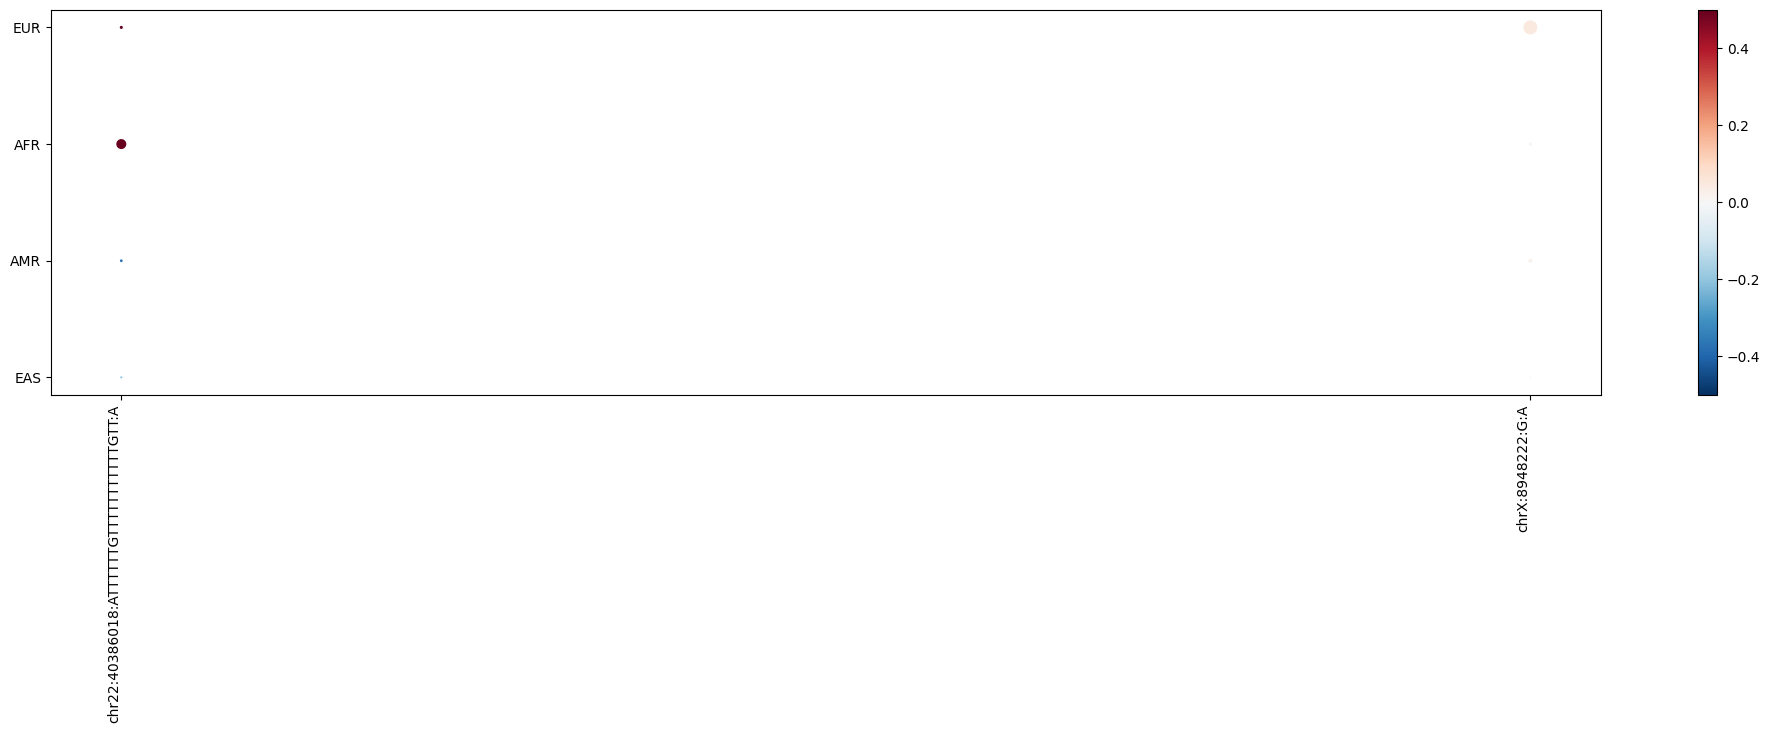

In [31]:
df_plot=format_clustermap(compiled_stats_noall, compiled_metal, "free")
df_plot["-log10p"]=-np.log10(df_plot["P"])
df_plot["-log10p"]=np.where(df_plot["-log10p"]>20,20,df_plot["-log10p"])

heatmap(
    x=df_plot['ID'],
    y=df_plot['group'],
    size=df_plot['-log10p'],
    color=df_plot['BETA'],
)

plt.savefig("../plots/metal/free.clustermap.pdf")

## Get ancestry-specific variants

### Evaluate beta values of ancestry-specific variants

In [32]:
compiled_stats_ancestry=compiled_stats[compiled_stats["ID"].isin(compiled_ancestry["SNP"].tolist()+compiled_metal["SNP"].tolist())]

In [33]:
len(compiled_stats_ancestry["ID"].unique())

262

In [34]:
compiled_stats_ancestry_oriented=pd.DataFrame()

#orient SNPs correctly
for x in compiled_stats_ancestry["ID"].unique():
    a1=compiled_stats_ancestry[compiled_stats_ancestry["ID"]==x]["A1"].value_counts().reset_index()["index"].tolist()[0]
    compiled_stats_snp=compiled_stats_ancestry[compiled_stats_ancestry["ID"]==x]
    compiled_stats_snp["BETA"]=np.where(compiled_stats_snp["A1"]!=a1,compiled_stats_snp["BETA"]*-1,compiled_stats_snp["BETA"])
    compiled_stats_snp["A1"]=a1
    compiled_stats_ancestry_oriented=compiled_stats_ancestry_oriented.append(compiled_stats_snp[compiled_stats_snp["group"]!="all"])

/tmp/ipykernel_3158443/1401701405.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compiled_stats_snp["BETA"]=np.where(compiled_stats_snp["A1"]!=a1,compiled_stats_snp["BETA"]*-1,compiled_stats_snp["BETA"])
/tmp/ipykernel_3158443/1401701405.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compiled_stats_snp["A1"]=a1


In [35]:
group_map={"all":0,"EUR":1,"AFR":2,"AMR":3,"EAS":4}

In [36]:
compiled_stats_ancestry_oriented["upper"]=compiled_stats_ancestry_oriented["BETA"]+(1.64*compiled_stats_ancestry_oriented["SE"])
compiled_stats_ancestry_oriented["lower"]=compiled_stats_ancestry_oriented["BETA"]-(1.64*compiled_stats_ancestry_oriented["SE"])

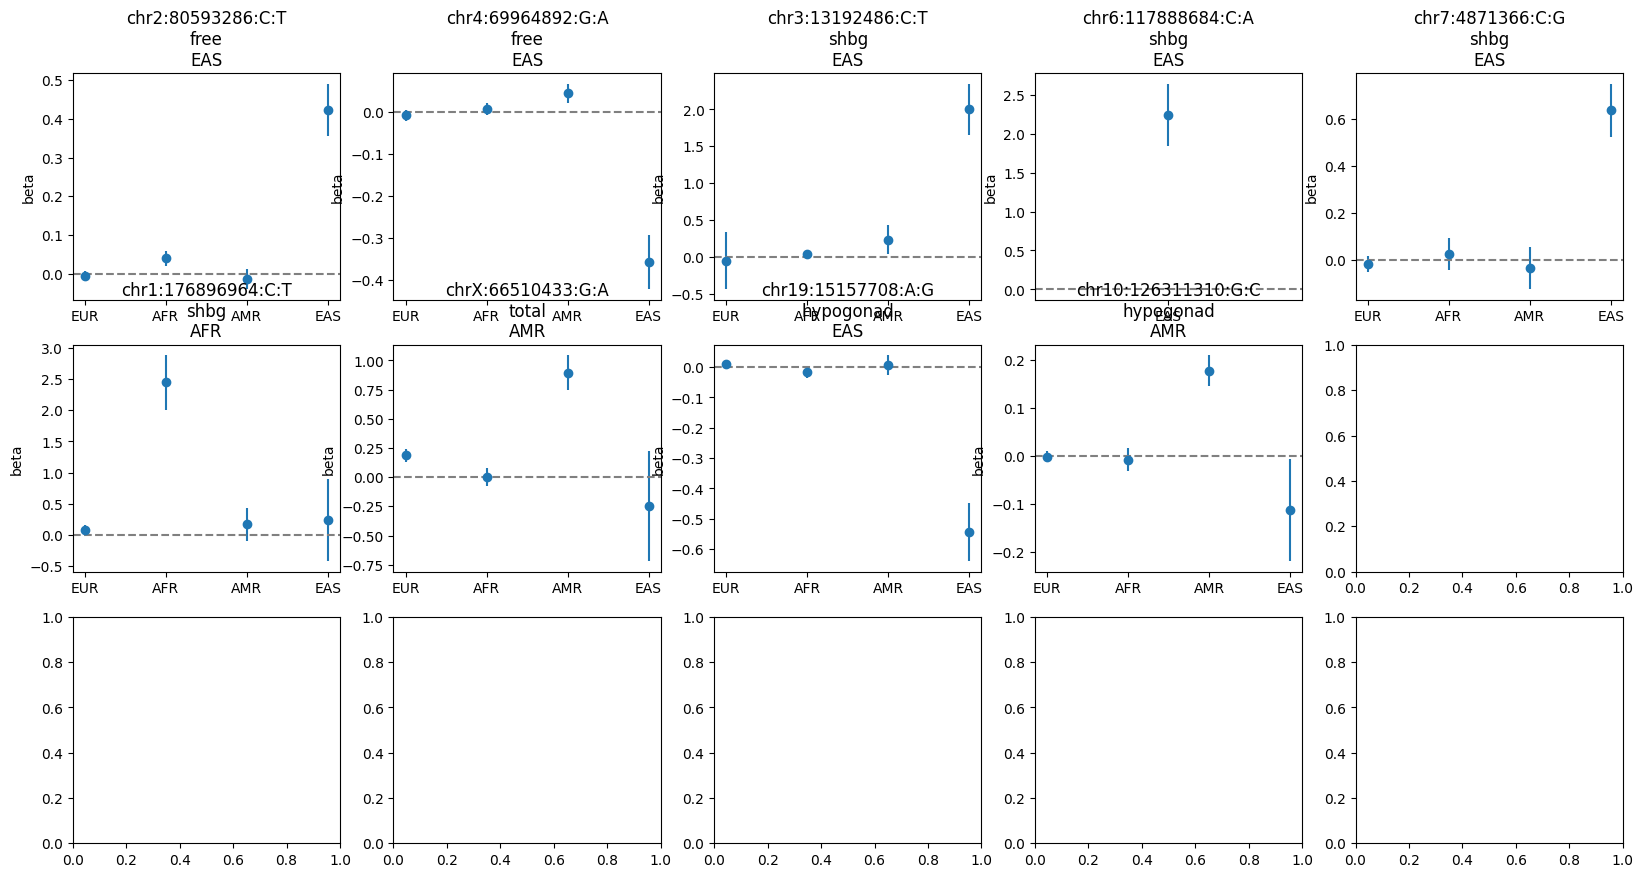

In [37]:
fig, axs = plt.subplots(3, 5, figsize=(20, 10))
axli = axs.flatten()
count=0

for i,row in compiled_ancestry.iterrows():
    #go through each ancestry SNP and see if CI overlap
    #filter to SNP
    df_snp=compiled_stats_ancestry_oriented[compiled_stats_ancestry_oriented["ID"]==row["SNP"]]
    df_snp=df_snp[df_snp["pheno"]==row["pheno"]]
    
    df_snp["group_map"]=df_snp["group"].map(group_map)
    df_snp=df_snp.sort_values(by="group_map")
    
    #get group threshold
    upp=df_snp[df_snp["group"]==row["group"]]["upper"].tolist()[0]
    low=df_snp[df_snp["group"]==row["group"]]["lower"].tolist()[0]
    
    #check dataframe
    df_check=df_snp[df_snp["group"]!=row["group"]]
    
    if (len(df_check[(df_check["upper"]>upp)&(df_check["lower"]<upp)])==0) & (len(df_check[(df_check["upper"]>low)&(df_check["lower"]<low)])==0):
        axli[count].set_title(row["SNP"]+"\n"+row["pheno"]+"\n"+row["group"])
        axli[count].errorbar(x="group",y="BETA",yerr="SE",data=df_snp,fmt="o")
        axli[count].axhline(0, linestyle="--",color="gray")
        axli[count].set_ylabel("beta")
        count+=1

plt.savefig("../plots/figs5.1.pdf")
        

In [38]:
het_snps=compiled_metal[compiled_metal["HetPVal"]<0.05]

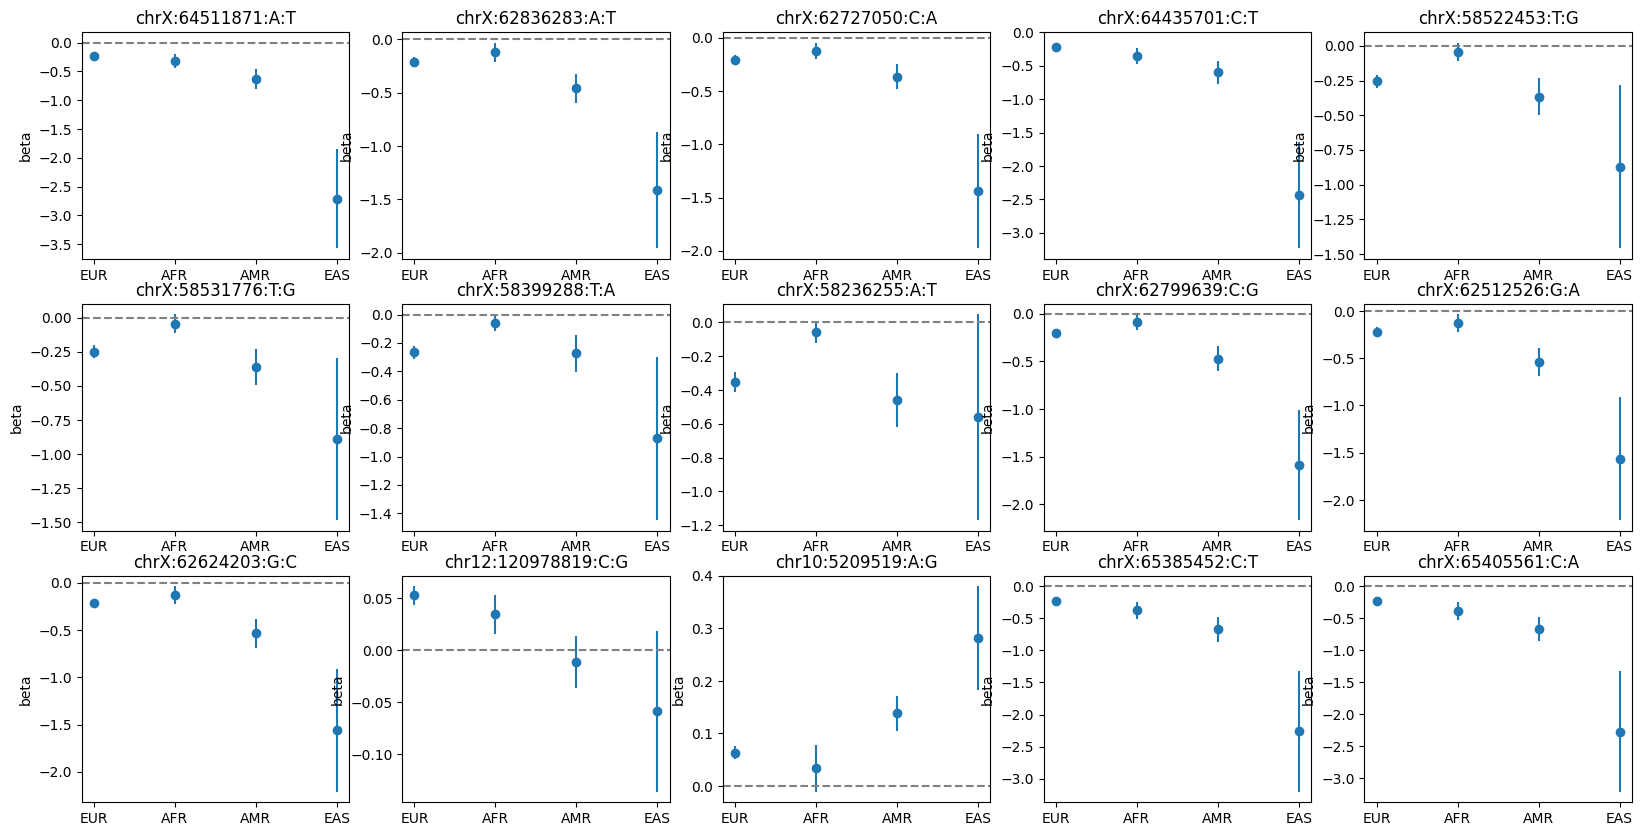

In [40]:
fig, axs = plt.subplots(3, 5, figsize=(20, 10))
axli = axs.flatten()
count=0

for i,row in het_snps[0:15].iterrows():
    #go through each ancestry SNP and see if CI overlap
    #filter to SNP
    df_snp=compiled_stats_ancestry_oriented[compiled_stats_ancestry_oriented["ID"]==row["SNP"]]
    df_snp=df_snp[df_snp["pheno"]==row["pheno"]]
    
    df_snp["group_map"]=df_snp["group"].map(group_map)
    df_snp=df_snp.sort_values(by="group_map")
    
#     axli[count].set_title(row["SNP"]+"\n"+row["pheno"]+"\n"+row["group"])
    axli[count].errorbar(x="group",y="BETA",yerr="SE",data=df_snp,fmt="o")
    axli[count].axhline(0, linestyle="--",color="gray")
    axli[count].set_ylabel("beta")
    axli[count].set_title(row["SNP"])
    count+=1

plt.savefig("../plots/figs5.2.pdf")

In [41]:
nonhet_snps=compiled_metal[compiled_metal["HetPVal"]>0.05]

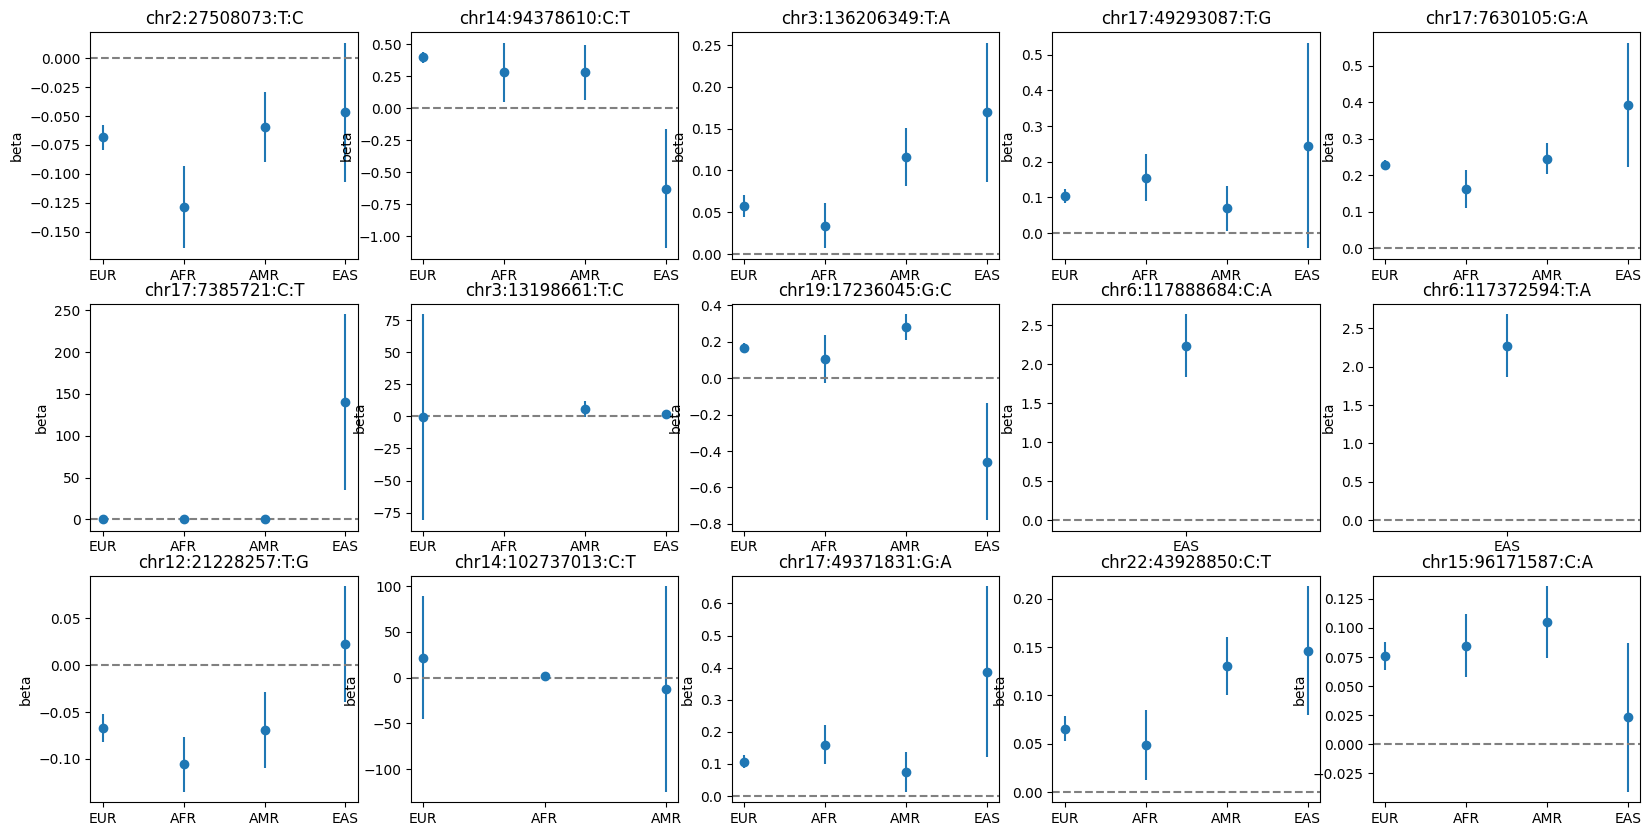

In [42]:
fig, axs = plt.subplots(3, 5, figsize=(20, 10))
axli = axs.flatten()
count=0

for i,row in nonhet_snps[0:15].iterrows():
    #go through each ancestry SNP and see if CI overlap
    #filter to SNP
    df_snp=compiled_stats_ancestry_oriented[compiled_stats_ancestry_oriented["ID"]==row["SNP"]]
    df_snp=df_snp[df_snp["pheno"]==row["pheno"]]
    
    df_snp["group_map"]=df_snp["group"].map(group_map)
    df_snp=df_snp.sort_values(by="group_map")
    
#     axli[count].set_title(row["SNP"]+"\n"+row["pheno"]+"\n"+row["group"])
    axli[count].errorbar(x="group",y="BETA",yerr="SE",data=df_snp,fmt="o")
    axli[count].axhline(0, linestyle="--",color="gray")
    axli[count].set_ylabel("beta")
    axli[count].set_title(row["SNP"])
    count+=1
    
plt.savefig("../plots/figs5.3.pdf")

### Incorporate SuSIE causality analysis

In [46]:
susie=pd.read_csv("../data/susie/compiled.susie.csv")
susie["SNP"]=susie["SNP"].str.replace("_",":")
susie_lst=[]

for i,row in compiled_ancestry.iterrows():
    susie_pheno=susie[susie["group"]==row["group"]]
    susie_pheno=susie_pheno[susie_pheno["SNP"].str.contains(row["pheno"])]
    susie_pheno=susie_pheno[susie_pheno["SNP"].str.contains(row["SNP"].rsplit(";",2)[0])]
    susie_pheno=susie_pheno[susie_pheno["ID"].str.contains(row["SNP"].rsplit(";",2)[0])]
    susie_lst.append(susie_pheno["fit.pip"].tolist()[0])

compiled_ancestry["susie"]=susie_lst

In [47]:
len(compiled_ancestry[compiled_ancestry["susie"]>0.1])

49

In [48]:
compiled_ancestry.to_csv("../data/supplemental/tables3.csv",index=None)

### Get PheWAS results

In [138]:
phewas=pd.read_csv("phewas.csv")
phewas.columns=["phecode", "snp","p","group"]

In [139]:
phewas["variant"]=phewas["snp"].str.replace("chr","")
phewas["variant"]=phewas["variant"].str.replace(".",":")
phewas["variant"]=phewas["variant"].str.rsplit(":",2).str[0]
phewas["snp"]=phewas["snp"].str.split("_").str[0]

/tmp/ipykernel_3158443/3448920327.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  phewas["variant"]=phewas["variant"].str.replace(".",":")


In [140]:
phewas_coloc=pd.read_csv("../data/phewas/compiled.coloc.results.csv")
phewas_coloc["group"]=phewas_coloc["file"].str.split(".").str[0]
phewas_coloc["phecode"]=phewas_coloc["file"].str.split(".").str[5]
phewas_coloc["snp"]=phewas_coloc["file"].str.split(".phe").str[0]
phewas_coloc["snp"]=phewas_coloc["snp"].str.split(".",1).str[1]
phewas_coloc["pheno"]=phewas_coloc["file"].str.split(".").str[6]
phewas_coloc=phewas_coloc[phewas_coloc["file"].str.contains(".p.summary.csv")]

In [141]:
check=compiled_ancestry[["SNP","group","pheno"]].drop_duplicates()
check["SNP"]=check["SNP"].str.replace(":",".")
check=check.rename(columns={"SNP":"snp"})

In [142]:
check=pd.merge(check, phewas, on=["snp","group"],how="left")

In [143]:
check=pd.merge(check, phewas_coloc, on=["snp","phecode","group","pheno"],how="left").drop_duplicates()

In [144]:
check=check[~check["phecode"].isnull()]

In [147]:
check["snp"]=check["snp"].str.replace(".",":")

/tmp/ipykernel_3158443/3885985775.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  check["snp"]=check["snp"].str.replace(".",":")


In [148]:
check.to_csv("../data/supplemental/phewas_table.csv",index=None)

In [92]:
df_phewas=phewas[["snp","phecode"]].drop_duplicates()
df_phewas["snp"]=df_phewas["snp"].str.replace(".",":")
mp_phewas=df_phewas.groupby('snp')['phecode'].apply(lambda x: ','.join(x)).reset_index()
mp_phewas=dict(zip(mp_phewas["snp"],mp_phewas["phecode"]))

/tmp/ipykernel_3158443/4058266081.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_phewas["snp"]=df_phewas["snp"].str.replace(".",":")


In [93]:
compiled_ancestry["phewas"]=compiled_ancestry["SNP"].map(mp_phewas)
compiled_metal["phewas"]=compiled_metal["SNP"].map(mp_phewas)

In [94]:
compiled_ancestry.to_csv("../data/supplemental/tables3.csv")
compiled_metal.to_csv("../data/supplemental/tables4.csv")

### Get UKBB validation

In [95]:
lifted=pd.read_csv("../data/testosterone.hg19.bed",header=None,delimiter="\t")
lifted["hg19_coord"]=lifted[0].astype(str)+":"+lifted[1].astype(str)
mp_hg19=dict(zip(lifted[3],lifted["hg19_coord"]))

In [96]:
ukbb_free=pd.read_csv("../data/ukbb/GCST90012103_buildGRCh37.tsv.gz",delimiter="\t")
ukbb_shbg=pd.read_csv("../data/ukbb/GCST90012109_buildGRCh37.tsv.gz",delimiter="\t")
ukbb_total=pd.read_csv("../data/ukbb/GCST90012113_buildGRCh37.tsv.gz",delimiter="\t")

In [97]:
ukbb_free["SNP"]="chr"+ukbb_free["chromosome"].astype(str)+":"+ukbb_free["base_pair_location"].astype(str)
ukbb_shbg["SNP"]="chr"+ukbb_shbg["chromosome"].astype(str)+":"+ukbb_shbg["base_pair_location"].astype(str)
ukbb_total["SNP"]="chr"+ukbb_total["chromosome"].astype(str)+":"+ukbb_total["base_pair_location"].astype(str)

In [98]:
compare=compiled_ancestry[compiled_ancestry["group"]=="EUR"]
compare["SNP"]=compare["SNP"].str.replace("chr","")
compare["hg19_coord"]=compare["SNP"].map(mp_hg19)
compare["hg19_coord"]=compare["hg19_coord"].str.replace("chrX","chr23")
compare=compare[compare["pheno"]!="hypogonad"]

/tmp/ipykernel_3158443/1919607113.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compare["SNP"]=compare["SNP"].str.replace("chr","")
/tmp/ipykernel_3158443/1919607113.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compare["hg19_coord"]=compare["SNP"].map(mp_hg19)
/tmp/ipykernel_3158443/1919607113.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan

In [99]:
proxy=pd.read_csv("../data/eur_proxy.csv")
proxy["GRCh37"]="chr"+proxy["GRCh37"]
proxy["GRCh37"]=proxy["GRCh37"].str.replace("chrX","chr23")
mp_proxy=dict(zip(proxy["SNP (GRCh38)"],proxy["GRCh37"]))

In [100]:
compare["proxy"]=compare["SNP"].map(mp_proxy).fillna(compare["hg19_coord"])

In [101]:
compare_ukbb=pd.DataFrame()
for pheno in ["total","free","shbg"]:
    compare_filt=compare[compare["pheno"]==pheno]
    compare_filt=compare_filt.rename(columns={"SNP":"MVP_id","proxy":"SNP"})
    if pheno == "total":
        compare_filt=pd.merge(compare_filt,ukbb_total[["SNP","beta","standard_error","p_value","effect_allele","other_allele"]],on="SNP",how="left")
        compare_ukbb=compare_ukbb.append(compare_filt)
    if pheno == "free":
        compare_filt=pd.merge(compare_filt,ukbb_free[["SNP","beta","standard_error","p_value","effect_allele","other_allele"]],on="SNP",how="left")
        compare_ukbb=compare_ukbb.append(compare_filt)
    if pheno == "shbg":
        compare_filt=pd.merge(compare_filt,ukbb_total[["SNP","beta","standard_error","p_value","effect_allele","other_allele"]],on="SNP",how="left")
        compare_ukbb=compare_ukbb.append(compare_filt)

In [102]:
len(compare_ukbb[compare_ukbb["p_value"]>(.05/len(compare_ukbb))])/len(compare_ukbb)

0.1276595744680851

In [103]:
compare_ukbb.to_csv("../data/supplemental/tables3.ukbb.csv")

In [104]:
compare_ukbb[compare_ukbb["p_value"]>(.05/len(compare_ukbb))]["pheno"].value_counts()

total    4
free     2
Name: pheno, dtype: int64

In [105]:
compare=compiled_metal.copy()
compare["SNP"]=compare["SNP"].str.replace("chr","")
compare["hg19_coord"]=compare["SNP"].map(mp_hg19)
compare["hg19_coord"]=compare["hg19_coord"].str.replace("chrX","chr23")
compare=compare[compare["pheno"]!="hypogonad"]

In [106]:
compare_ukbb=pd.DataFrame()
for pheno in ["total","free","shbg"]:
    compare_filt=compare[compare["pheno"]==pheno]
    compare_filt=compare_filt.rename(columns={"SNP":"MVP_id","hg19_coord":"SNP"})
    if pheno == "total":
        compare_filt=pd.merge(compare_filt,ukbb_total[["SNP","beta","standard_error","p_value","effect_allele","other_allele"]],on="SNP",how="left")
        compare_ukbb=compare_ukbb.append(compare_filt)
    if pheno == "free":
        compare_filt=pd.merge(compare_filt,ukbb_free[["SNP","beta","standard_error","p_value","effect_allele","other_allele"]],on="SNP",how="left")
        compare_ukbb=compare_ukbb.append(compare_filt)
    if pheno == "shbg":
        compare_filt=pd.merge(compare_filt,ukbb_total[["SNP","beta","standard_error","p_value","effect_allele","other_allele"]],on="SNP",how="left")
        compare_ukbb=compare_ukbb.append(compare_filt)

In [107]:
proxy=compare_ukbb[compare_ukbb["p_value"].isnull()]

In [108]:
proxy_lst=[]
snp_list=[]

for i, row in proxy.iterrows():
    check=ukbb_total[ukbb_total["chromosome"]==row["CHR"]]
    check["diff"]=abs(check["base_pair_location"]-row["BP"])
    top=check.sort_values(by="diff")["SNP"].tolist()[0]
    proxy_lst.append(top)
    snp_list.append(row["SNP"])

/tmp/ipykernel_3158443/1800627444.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  check["diff"]=abs(check["base_pair_location"]-row["BP"])


In [109]:
df_proxy=pd.DataFrame({"proxy_lst":proxy_lst, "snp_lst":snp_list})
mp_proxy=dict(zip(df_proxy["snp_lst"],df_proxy["proxy_lst"]))
compare["proxy"]=compare["hg19_coord"].map(mp_proxy).fillna(compare["hg19_coord"])

In [110]:
compare_ukbb=pd.DataFrame()
for pheno in ["total","free","shbg"]:
    compare_filt=compare[compare["pheno"]==pheno]
    compare_filt=compare_filt.rename(columns={"SNP":"MVP_id","proxy":"SNP"})
    if pheno == "total":
        compare_filt=pd.merge(compare_filt,ukbb_total[["SNP","beta","standard_error","p_value","effect_allele","other_allele"]],on="SNP",how="left")
        compare_ukbb=compare_ukbb.append(compare_filt)
    if pheno == "free":
        compare_filt=pd.merge(compare_filt,ukbb_free[["SNP","beta","standard_error","p_value","effect_allele","other_allele"]],on="SNP",how="left")
        compare_ukbb=compare_ukbb.append(compare_filt)
    if pheno == "shbg":
        compare_filt=pd.merge(compare_filt,ukbb_total[["SNP","beta","standard_error","p_value","effect_allele","other_allele"]],on="SNP",how="left")
        compare_ukbb=compare_ukbb.append(compare_filt)

In [111]:
compare_ukbb.to_csv("../data/supplemental/tables4.ukbb.csv")

In [112]:
len(compare_ukbb[compare_ukbb["p_value"]<(.05/len(compare_ukbb))])/len(compare_ukbb)

0.6410256410256411

### Get quantile plots

In [117]:
quantile=pd.read_csv("../data/coxph/compiled.quantile.results.csv")

In [118]:
quantile["quantile\tbeta\tse"]=np.where(quantile["quantile\tbeta\tse"].isnull(),quantile["quant\todds\tse"],quantile["quantile\tbeta\tse"])

In [119]:
quantile["quantile"]=quantile["quantile\tbeta\tse"].str.split("\t").str[0]
quantile["beta"]=quantile["quantile\tbeta\tse"].str.split("\t").str[1]
quantile["beta"]=quantile["beta"].astype(float)
quantile["se"]=quantile["quantile\tbeta\tse"].str.split("\t").str[2]
quantile["se"]=quantile["se"].astype(float)
quantile["PRS"]=quantile["file"].str.split(".").str[0]
quantile["group"]=quantile["file"].str.split(".").str[2]
quantile["pheno"]=quantile["file"].str.split(".").str[3]

/tmp/ipykernel_3158443/3841564910.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quantile_pheno["beta"]=np.where(quantile_pheno["quantile"]!="5",np.exp(quantile_pheno["beta"]),quantile_pheno["beta"])


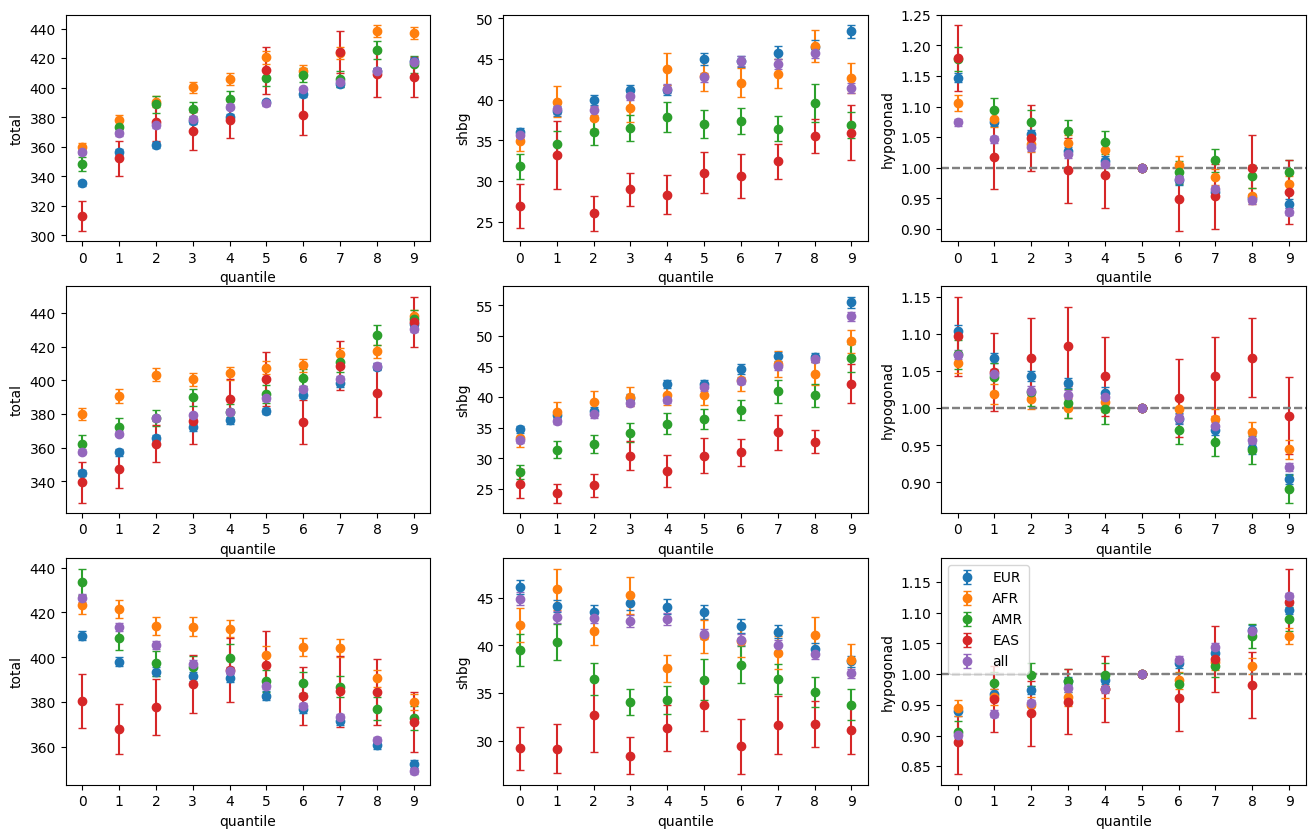

In [120]:
fig, axs = plt.subplots(3, 3, figsize=(16, 10))
axli = axs.flatten()

count=0
for x in ["total","shbg","hypogonad"]:
    for y in ["total","shbg","hypogonad"]:
        quantile_pheno=quantile[(quantile["PRS"]==x)&(quantile["pheno"]==y)]
        if y == "hypogonad":
            quantile_pheno["beta"]=np.where(quantile_pheno["quantile"]!="5",np.exp(quantile_pheno["beta"]),quantile_pheno["beta"])
            
        for group in ["EUR","AFR","AMR","EAS","all"]:
            quantile_pheno_group=quantile_pheno[quantile_pheno["group"]==group]
            axli[count].errorbar(quantile_pheno_group["quantile"].tolist(), quantile_pheno_group["beta"].tolist(),yerr=quantile_pheno_group["se"].tolist(),fmt="o",label=group,capsize=3)
            axli[count].set_xlabel("quantile")
            axli[count].set_ylabel(y)
            
            if y == "hypogonad":
                axli[count].axhline(1,linestyle="--",color="grey")
        count+=1
        
plt.legend()
plt.savefig("../plots/fig4.pdf")

### Get coxph results

In [121]:
coxph=pd.read_csv("../data/coxph/compiled.coxph.exclude.results.csv")

In [122]:
coxph["phecode"]=coxph["file"].str.split(".").str[1]
coxph["PRS"]=coxph["file"].str.split(".").str[0]
coxph["group"]=coxph["file"].str.split(".").str[2]
coxph["odds"]=np.exp(coxph["beta"])

In [123]:
coxph["group_order"]=coxph["group"].map({"all":1,"EUR":2,"AFR":3,"AMR":4,"EAS":5})

In [124]:
coxph["upper"]=coxph["odds"]+coxph["se"]
coxph["lower"]=coxph["odds"]-coxph["se"]

In [125]:
coxph=coxph[coxph["group"]!="all"]

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


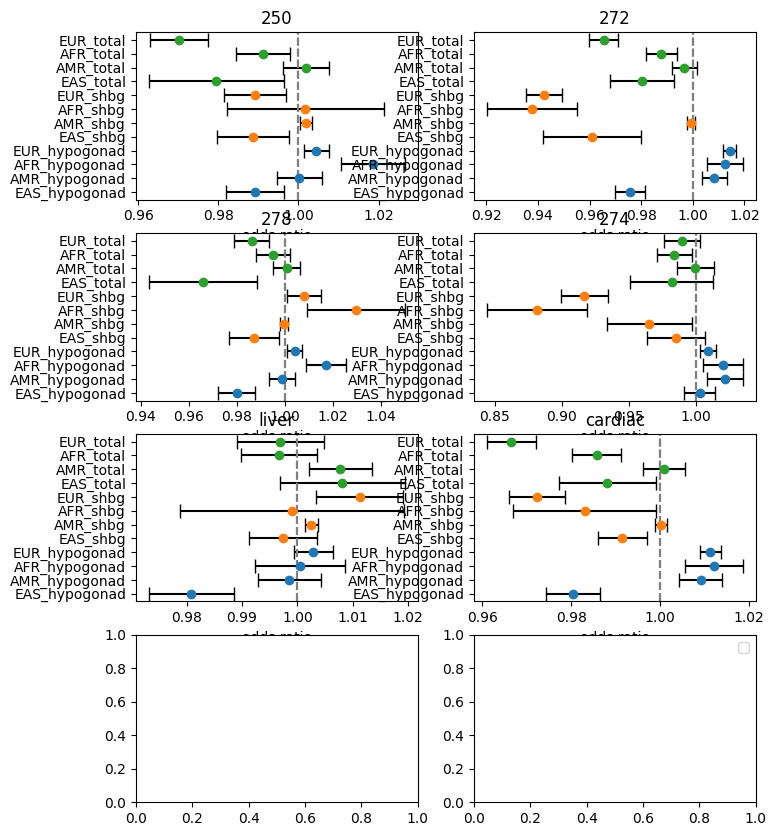

In [126]:
fig, axs = plt.subplots(4, 2, figsize=(8, 10))
axli = axs.flatten()

count=0
for y in ["250","272","278","274","liver","cardiac"]:
    for x in ["hypogonad","shbg","total"]:
        coxph_pheno=coxph[(coxph["PRS"]==x)&(coxph["phecode"]==y)]
        coxph_pheno=coxph_pheno.sort_values(by="group_order",ascending=False)
        coxph_pheno["set"]=coxph_pheno["group"]+"_"+coxph_pheno["PRS"]
        axli[count].errorbar(coxph_pheno["odds"].tolist(), coxph_pheno["set"].tolist(),xerr=coxph_pheno["se"].tolist(),fmt="o",ecolor="black",capsize=5,label=x)
        axli[count].set_xlabel("odds ratio")
        axli[count].set_title(y)    
        axli[count].axvline(1,linestyle="--",color="grey")
    plt.legend()
    count+=1
    
plt.savefig("../plots/fig5.pdf")

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


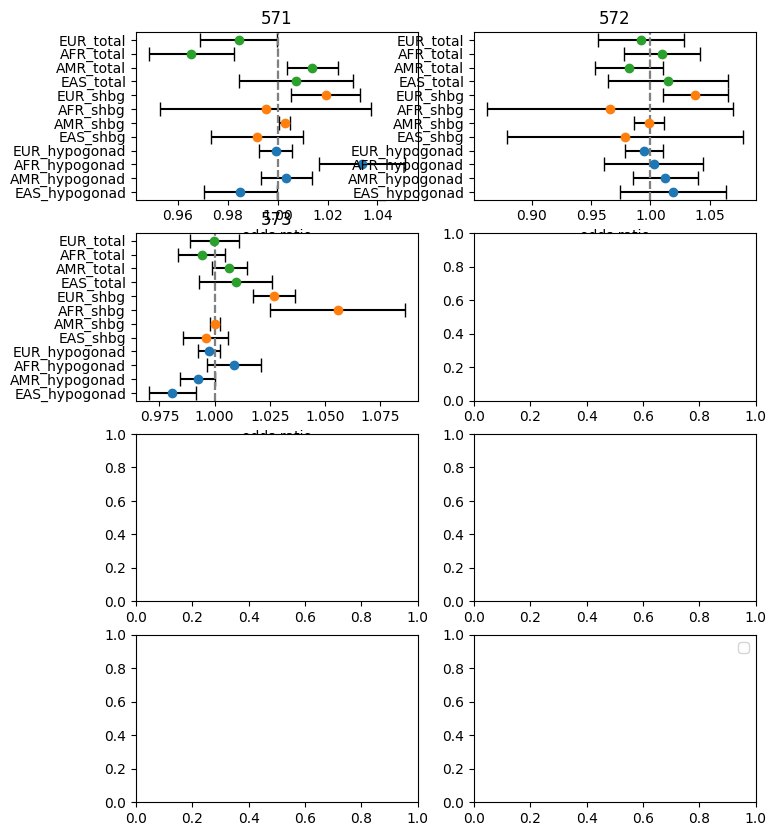

In [127]:
fig, axs = plt.subplots(4, 2, figsize=(8, 10))
axli = axs.flatten()

count=0
for y in ["571","572","573"]:
    for x in ["hypogonad","shbg","total"]:
        coxph_pheno=coxph[(coxph["PRS"]==x)&(coxph["phecode"]==y)]
        coxph_pheno=coxph_pheno.sort_values(by="group_order",ascending=False)
        coxph_pheno["set"]=coxph_pheno["group"]+"_"+coxph_pheno["PRS"]
        axli[count].errorbar(coxph_pheno["odds"].tolist(), coxph_pheno["set"].tolist(),xerr=coxph_pheno["se"].tolist(),fmt="o",ecolor="black",capsize=5,label=x)
        axli[count].set_xlabel("odds ratio")
        axli[count].set_title(y)    
        axli[count].axvline(1,linestyle="--",color="grey")
    plt.legend()
    count+=1
    
plt.savefig("../plots/fig5.2.pdf")

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


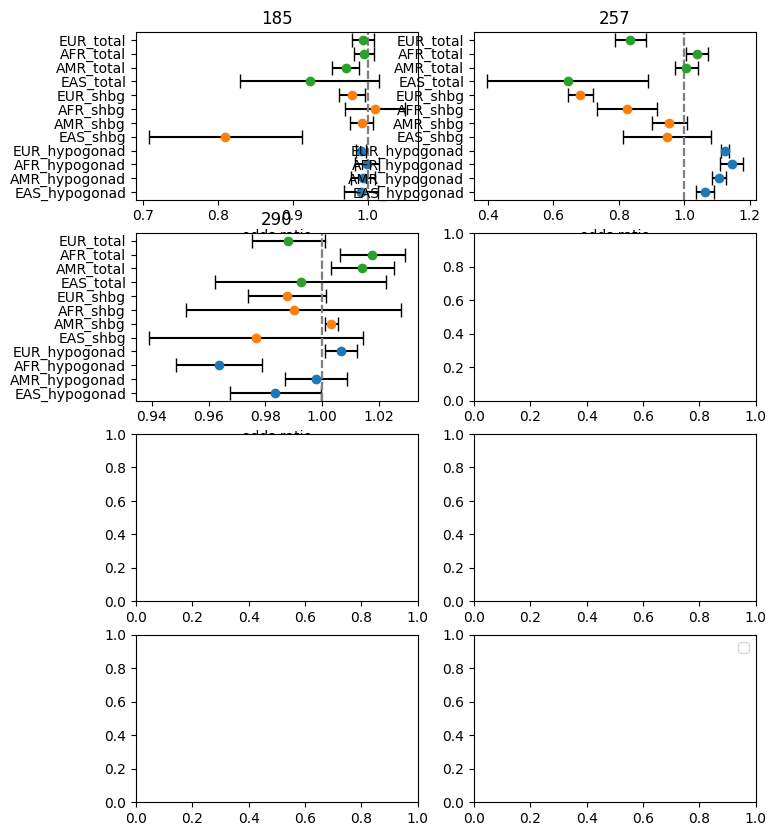

In [66]:
fig, axs = plt.subplots(4, 2, figsize=(8, 10))
axli = axs.flatten()

count=0
for y in ["185","257","290"]:
    for x in ["hypogonad","shbg","total"]:
        coxph_pheno=coxph[(coxph["PRS"]==x)&(coxph["phecode"]==y)]
        coxph_pheno=coxph_pheno.sort_values(by="group_order",ascending=False)
        coxph_pheno["set"]=coxph_pheno["group"]+"_"+coxph_pheno["PRS"]
        axli[count].errorbar(coxph_pheno["odds"].tolist(), coxph_pheno["set"].tolist(),xerr=coxph_pheno["se"].tolist(),fmt="o",ecolor="black",capsize=5,label=x)
        axli[count].set_xlabel("odds ratio")
        axli[count].set_title(y)    
        axli[count].axvline(1,linestyle="--",color="grey")
    plt.legend()
    count+=1
    
plt.savefig("../plots/fig5.2.pdf")

### Map variants to genes

In [155]:
#get clumps
clump_dir="../data/metal/"
clump_files=[x for x in os.listdir(clump_dir) if x.endswith(".csv")]

compiled_clumps=pd.DataFrame()
for x in clump_files:
    df=pd.read_csv(clump_dir+x)
    df["pheno"]=x.split(".")[2]
    df["group"]="metal"
    compiled_clumps=compiled_clumps.append(df)
    
direct="../data/clumps/"
files=[x for x in os.listdir(direct) if "sig" in x]
files=[x for x in files if "all" not in x]

for x in files:
    try:
        df=pd.read_csv(direct+x)
        df["pheno"]=x.split(".")[0]
        df["group"]=x.split(".")[1]
        compiled_clumps=compiled_clumps.append(df)
    except:
        print(x)

compiled_clumps=compiled_clumps[["SNP","pheno","group"]]
snps=[x.replace(":","_") for x in compiled_clumps["SNP"].tolist()]
snps=snps+[x.rsplit("_",2)[0]+"_"+x.split("_")[3]+"_"+x.split("_")[2] for x in snps]
snps=[x+"_b38" for x in snps]

free.AMR.sig.compiled.clumps.csv


In [157]:
len(snps)

690

In [160]:
files=[x for x in os.listdir("/cellar/users/mpagadal/data/gtex/GTEx_Analysis_v8_eQTL/") if "sig" in x]
gtex_compiled=pd.DataFrame()

for x in files:
    print(x)
    df=pd.read_csv("/cellar/users/mpagadal/data/gtex/GTEx_Analysis_v8_eQTL/"+x,delimiter="\t")
    df[df["variant_id"].isin(snps)]
    df["gene"]=x
    gtex_compiled=gtex_compiled.append(df)

Uterus.v8.signif_variant_gene_pairs.txt
Esophagus_Mucosa.v8.signif_variant_gene_pairs.txt
Vagina.v8.signif_variant_gene_pairs.txt
Brain_Hypothalamus.v8.signif_variant_gene_pairs.txt
Heart_Left_Ventricle.v8.signif_variant_gene_pairs.txt
Brain_Cerebellum.v8.signif_variant_gene_pairs.txt
Brain_Amygdala.v8.signif_variant_gene_pairs.txt
Pancreas.v8.signif_variant_gene_pairs.txt
Spleen.v8.signif_variant_gene_pairs.txt
Skin_Not_Sun_Exposed_Suprapubic.v8.signif_variant_gene_pairs.txt
Brain_Nucleus_accumbens_basal_ganglia.v8.signif_variant_gene_pairs.txt
Adipose_Subcutaneous.v8.signif_variant_gene_pairs.txt
Heart_Atrial_Appendage.v8.signif_variant_gene_pairs.txt
Esophagus_Muscularis.v8.signif_variant_gene_pairs.txt
Colon_Transverse.v8.signif_variant_gene_pairs.txt
Brain_Caudate_basal_ganglia.v8.signif_variant_gene_pairs.txt
Nerve_Tibial.v8.signif_variant_gene_pairs.txt
Small_Intestine_Terminal_Ileum.v8.signif_variant_gene_pairs.txt
Ovary.v8.signif_variant_gene_pairs.txt
Cells_Cultured_fibroblas

In [163]:
gtex_compiled_filt=gtex_compiled[gtex_compiled["variant_id"].isin(snps)]
gtex_compiled_filt["gene2"]=gtex_compiled_filt["gene_id"].str.split(".").str[0]
gtex_compiled_filt["gene_name"]=gtex_compiled_filt["gene2"].map(ensembl)
gtex_gene_assoc=gtex_compiled_filt[["variant_id","gene_name"]].drop_duplicates()
pd.DataFrame({"genes":gtex_compiled_filt["gene_id"].unique()}).to_csv("../data/coloc/gtex.significant.genes.metal.txt",header=None,index=None,sep="\t")

/tmp/ipykernel_2527124/121651985.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gtex_compiled_filt["gene2"]=gtex_compiled_filt["gene_id"].str.split(".").str[0]
/tmp/ipykernel_2527124/121651985.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gtex_compiled_filt["gene_name"]=gtex_compiled_filt["gene2"].map(ensembl)


### Get coloc results

In [14]:
coloc_input="../data/coloc/coloc_input/"
coloc_output="../data/coloc/coloc_output/"

# collect collection of p value colocalization results

compiled=pd.DataFrame()

for pheno in ["total","free","shbg","hypogonad"]:
    for group in ["EUR"]:
        files=[x for x in os.listdir(coloc_output+pheno+"/"+group) if "p.summary.csv" in x]
        files=[x for x in files if "compiled" not in x]
        for cell in ["Testis","Adrenal_Gland","Liver"]:
            print(pheno)
            print(group)
            files_cell=[x for x in files if cell in x]
            for i,x in enumerate(files_cell):
                if i %100 ==0:
                    print("{}/{} files compiled".format(i,len(files_cell)))
                df=pd.read_csv(coloc_output+pheno+"/"+group+"/"+x,index_col=0)
                df=df.T
                df["file"]=x
                df["pheno"]=pheno
                df["group"]=group
                compiled=compiled.append(df)
# compiled.to_csv("../data/coloc/coloc.results.csv")

total
EUR
0/388 files compiled
100/388 files compiled
200/388 files compiled
300/388 files compiled
total
EUR
0/346 files compiled
100/346 files compiled
200/346 files compiled
300/346 files compiled
total
EUR
0/349 files compiled
100/349 files compiled
200/349 files compiled
300/349 files compiled
free
EUR
0/388 files compiled
100/388 files compiled
200/388 files compiled
300/388 files compiled
free
EUR
0/346 files compiled
100/346 files compiled
200/346 files compiled
300/346 files compiled
free
EUR
0/349 files compiled
100/349 files compiled
200/349 files compiled
300/349 files compiled
shbg
EUR
0/388 files compiled
100/388 files compiled
200/388 files compiled
300/388 files compiled
shbg
EUR
0/346 files compiled
100/346 files compiled
200/346 files compiled
300/346 files compiled
shbg
EUR
0/349 files compiled
100/349 files compiled
200/349 files compiled
300/349 files compiled
hypogonad
EUR
0/388 files compiled
100/388 files compiled
200/388 files compiled
300/388 files compiled
hy

In [15]:
compiled["gene"]=compiled["file"].str.split(".").str[1]
compiled["gene_name"]=compiled["gene"].map(ensembl)
compiled["cell"]=compiled["file"].str.split(".").str[0]

In [16]:
compiled["pheno"]=compiled["pheno"].replace("hypogonad2","hypogonad")

In [17]:
compiled_sig=compiled[compiled["PP.H4.abf"]>0.8]

In [39]:
compiled_sig=compiled_sig[compiled_sig["group"]=="EUR"]

In [40]:
total_genes=compiled_sig[compiled_sig["pheno"]=="total"]["gene_name"].unique().tolist()
shbg_genes=compiled_sig[compiled_sig["pheno"]=="shbg"]["gene_name"].unique().tolist()
hypogonad_genes=compiled_sig[compiled_sig["pheno"]=="hypogonad"]["gene_name"].unique().tolist()

In [130]:
testis_genes=compiled_sig[compiled_sig["cell"]=="Testis"]["gene_name"].unique().tolist()
liver_genes=compiled_sig[compiled_sig["cell"]=="Liver"]["gene_name"].unique().tolist()
adrenal_genes=compiled_sig[compiled_sig["cell"]=="Adrenal_Gland"]["gene_name"].unique().tolist()

In [97]:
compiled_plot=compiled[(compiled["group"]=="EUR")&(compiled["pheno"]=="hypogonad")]

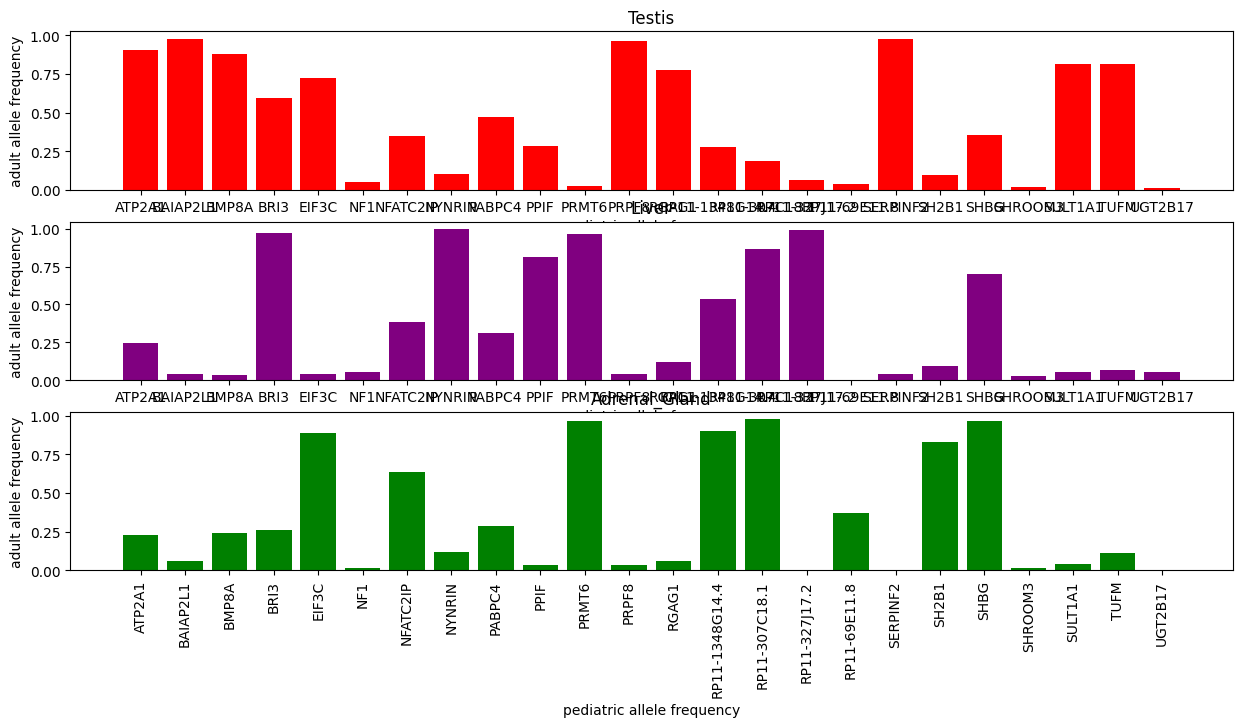

In [98]:
fig, axs = plt.subplots(3, 1, figsize=(15, 7))
axli = axs.flatten()

mp_color={"Adrenal_Gland":"green","Liver":"purple","Testis":"red"}

for i,pheno in enumerate(["Testis","Liver","Adrenal_Gland"]):
    compiled_plot_pheno=compiled_plot[compiled_plot["cell"]==pheno]
    
    df_sig=pd.DataFrame({"gene_name":compiled_sig["gene_name"].unique().tolist()})
    compiled_plot_pheno=pd.merge(df_sig, compiled_plot_pheno[["gene_name","PP.H4.abf"]],on="gene_name",how="left")
    compiled_plot_pheno=compiled_plot_pheno.fillna(0)
    compiled_plot_pheno=compiled_plot_pheno.sort_values(by="gene_name")
    
    axli[i].bar(compiled_plot_pheno["gene_name"],compiled_plot_pheno["PP.H4.abf"],color=mp_color[pheno])
    axli[i].set_xlabel("pediatric allele frequency")
    axli[i].set_ylabel("adult allele frequency")
    axli[i].set_title(pheno)
    plt.xticks(rotation=90)
    
plt.savefig("../plots/coloc.eur.hypogonad.pdf")

In [ ]:
tables6=compiled[compiled["gene"].isin(compiled_sig["gene"].tolist())]
tables6["group_pheno"]=tables6["group"]+"_"+tables6["pheno"]

In [ ]:
tables6_testis=tables6[tables6["cell"]=="Testis"].pivot(index="gene",columns="group_pheno",values="PP.H4.abf")
tables6_liver=tables6[tables6["cell"]=="Liver"].pivot(index="gene",columns="group_pheno",values="PP.H4.abf")
tables6_adrenal=tables6[tables6["cell"]=="Adrenal_Gland"].pivot(index="gene",columns="group_pheno",values="PP.H4.abf")

In [ ]:
tables6_combo=pd.merge(tables6_testis,tables6_liver, left_index=True, right_index=True, suffixes=("_testis","_liver"),how="outer")
tables6_combo=pd.merge(tables6_combo,tables6_adrenal, left_index=True, right_index=True, how="outer")

In [ ]:
tables6_combo["gene_name"]=tables6_combo.index.map(ensembl)

In [ ]:
tables6_combo.shape

In [ ]:
tables6_combo.to_csv("../supplemental/tables6.csv")

## Make gene circos track

In [128]:
gtex_circos_track=compiled_sig[["gene_name","cell"]].drop_duplicates().groupby('gene_name')['cell'].apply(lambda x: ','.join(x)).reset_index()

In [129]:
vep_genes=vep_output[vep_output["#Uploaded_variation"].isin(compiled_metal["SNP"].tolist()+[x.split(":",2)[0]+":"+x.split(":")[3]+":"+x.split(":")[2] for x in compiled_metal["SNP"].tolist()])]["SYMBOL"].unique().tolist()

In [131]:
vep_circos_track=pd.DataFrame({"gene_name":vep_genes,"cell":"vep"})
vep_circos_track=vep_circos_track[vep_circos_track["gene_name"]!="-"]
vep_circos_track=vep_circos_track[~vep_circos_track["gene_name"].isin(gtex_circos_track["gene_name"].tolist())]

In [135]:
gene_circos_track=gtex_circos_track.append(vep_circos_track)

In [184]:
#get gene locations
annot=pd.read_csv("/cellar/users/mpagadal/resources/annotations/gencode.v37.annotation.gff3",comment="#",delimiter="\t",header=None)
annot["gene_name"]=annot[8].str.split("gene_name=").str[1]
annot["gene_name"]=annot["gene_name"].str.split(";").str[0]
annot["gene_type"]=annot[8].str.split("gene_type=").str[1]
annot["gene_type"]=annot["gene_type"].str.split(";").str[0]
annot["chr"]=annot[0].str.replace("chr","hs")
annot["bp1"]=annot[3].astype(int)
annot["bp2"]=annot["bp1"]+1
annot=annot[annot[2]=="gene"]

In [185]:
annot=annot[annot["gene_name"].isin(gene_circos_track["gene_name"].tolist())]

In [186]:
extra_annot=pd.read_csv("extra_genes.csv")
annot=annot.append(extra_annot)

In [189]:
gene_circos_track=pd.merge(gene_circos_track,annot[["gene_name","chr","bp1","bp2"]],on="gene_name",how="left")

In [194]:
gene_circos_track=gene_circos_track[["chr","bp1","bp2","gene_name","cell"]]

In [203]:
#color genes by tissue specificity
mp_color={"Adrenal_Gland":"color=green",
          "Liver":"color=blue",
          "Testis":"color=red",
          "Adrenal_Gland,Testis":"color=purple",
          "Adrenal_Gland,Liver":"color=purple",
          "vep":"color=gray"}

gene_circos_track["color"]=gene_circos_track["cell"].map(mp_color)

/tmp/ipykernel_2217252/1488916988.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gene_circos_track["color"]=gene_circos_track["cell"].map(mp_color)


In [204]:
genes_circos=gene_circos_track[["chr","bp1","bp2","gene_name","color"]]
genes_circos.to_csv("../data/circos/labels/genes.txt",index=None,header=None,sep="\t")

### Plot hypogonad frequency

In [90]:
cases=[146720,102635, 27736, 13328, 1690]
total=[588177, 421613, 105305, 50829,9154]

In [91]:
freq=[]

for i,x in enumerate(cases):
    freq.append(cases[i]/total[i])

In [ ]:
plt.figure(figsize=(5,5))
plt.bar(["all","EUR","AFR","AMR","EAS"],freq)
plt.ylabel("frequency")
plt.xticks(rotation=90)
plt.savefig("hypogonad.freq.pdf")